# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построитт модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.  

Данные геологоразведки трёх регионов:  
id — уникальный идентификатор скважины;  
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
product — объём запасов в скважине (тыс. баррелей).  

Бюджет на разработку скважин в регионе — 10 млрд рублей.  
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

Подключим библиотеки

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from numpy.random import RandomState
import os
import matplotlib.pyplot as plt

Введем константы

In [3]:
STATE = RandomState(12345)
BUDGET = 10 ** 10 # общий бюджет на разработку скважин
ONE_THOUSAND_BARREL_COST = 450000 # стоимость одной тысячи баррелей нефти
WELL_COUNT = 200 # количество скважин, которые будут разрабатывать
WELLS_BOOTSTRAP = 500

Загрузим данные

In [9]:
pth1 = 'geo_data_0.csv'
pth2 = 'https://code.s3.yandex.net/datasets/geo_data_0.csv'
    
if os.path.exists(pth1):
    geo_data_0 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    geo_data_0 = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
pth3 = 'geo_data_1.csv'
pth4 = 'https://code.s3.yandex.net/datasets/geo_data_1.csv'
    
if os.path.exists(pth3):
    geo_data_1 = pd.read_csv(pth3)
elif os.path.exists(pth4):
    geo_data_1 = pd.read_csv(pth4)
else:
    print('Something is wrong')
    
pth5 = 'geo_data_2.csv'
pth6 = 'https://code.s3.yandex.net/datasets/geo_data_2.csv'
    
if os.path.exists(pth5):
    geo_data_2 = pd.read_csv(pth5)
elif os.path.exists(pth6):
    geo_data_2 = pd.read_csv(pth6)
else:
    print('Something is wrong')

Посмотрим что представляют эти данные

In [10]:
def df_information(df):
    print(df.head())
    print(df.info())
    print(df.describe())

In [11]:
df_information(geo_data_0)

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      4

In [12]:
df_information(geo_data_1)

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.7

In [13]:
df_information(geo_data_2)

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      4

Данные представляют из себя три таблицы, в каждой из которых по 10000 строк и 5 столбцов.  

Проверим наличие дубликатов

In [14]:
print(geo_data_0.duplicated().sum())
print(geo_data_1.duplicated().sum())
print(geo_data_2.duplicated().sum())

0
0
0


In [15]:
print(geo_data_0.duplicated(subset=['id']).sum())
print(geo_data_1.duplicated(subset=['id']).sum())
print(geo_data_2.duplicated(subset=['id']).sum())

10
4
4


В данных присутствуют неявные дубликаты, так как их не много, то избавимся от них

In [16]:
geo_data_0 = geo_data_0.drop_duplicates(subset=['id'])
geo_data_1 = geo_data_1.drop_duplicates(subset=['id'])
geo_data_2 = geo_data_2.drop_duplicates(subset=['id'])

Проверим что у нас получилось

In [17]:
print(geo_data_0.duplicated(subset=['id']).sum())
print(geo_data_1.duplicated(subset=['id']).sum())
print(geo_data_2.duplicated(subset=['id']).sum())

0
0
0


Все дубликаты удалены

Избавимся от столбцов с номерами скважен, так как названия не влияют на другие параметры скважин

In [18]:
geo_data_0 = geo_data_0.drop(columns=['id'])

In [19]:
geo_data_1 = geo_data_1.drop(columns=['id'])

In [20]:
geo_data_2 = geo_data_2.drop(columns=['id'])

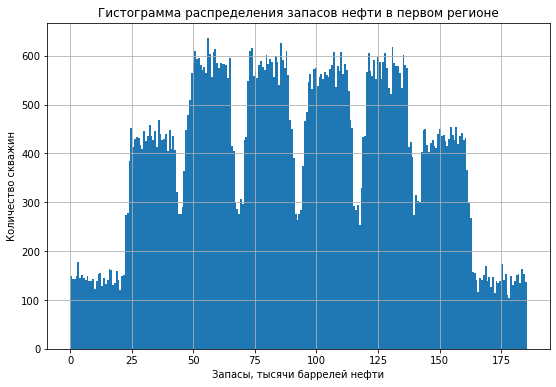

In [21]:
geo_data_0.hist(
    column='product',
    figsize=[9,6],
    bins=250)
plt.title('Гистограмма распределения запасов нефти в первом регионе')
plt.xlabel('Запасы, тысячи баррелей нефти')
plt.ylabel('Количество скважин')
plt.show()

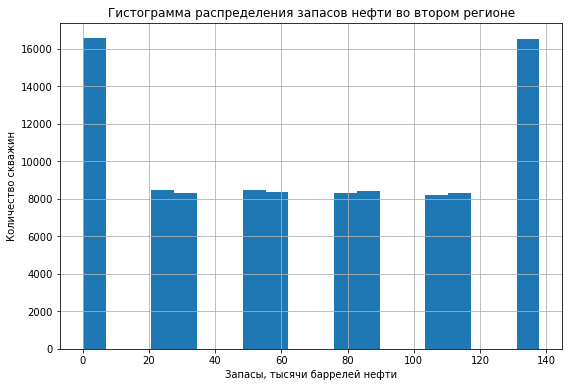

In [22]:
geo_data_1.hist(
    column='product',
    figsize=[9,6],
    bins=20)
plt.title('Гистограмма распределения запасов нефти во втором регионе')
plt.xlabel('Запасы, тысячи баррелей нефти')
plt.ylabel('Количество скважин')
plt.show()

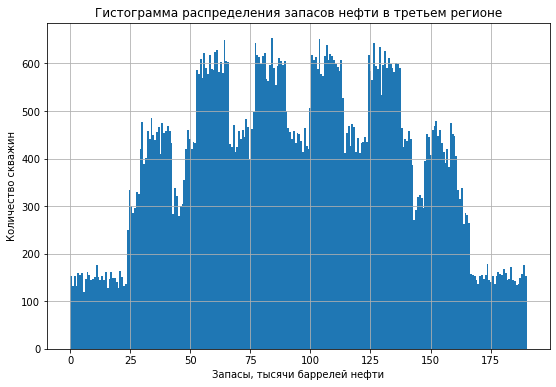

In [23]:
geo_data_2.hist(
    column='product',
    figsize=[9,6],
    bins=250)
plt.title('Гистограмма распределения запасов нефти в третьем регионе')
plt.xlabel('Запасы, тысячи баррелей нефти')
plt.ylabel('Количество скважин')
plt.show()

Из гистограмм видно, что в первом и третьем регионе мало точек с очень малым (меньше 25 тысяч баррелей и большим количеством нефи (больше 170 тысяч баррелей), по четыре участка со средним запасом нефти и два участка с малым количеством нефти,  
во втором регионе больше всего скважин с очень малым и очень большим количество нефти и четыре участка со средним значением нефти, при этом промежуточные скважины (по количеству нефти) отсутствуют

Посмотрим на матрицы корреляции

In [24]:
print(geo_data_0.corr())
print(geo_data_1.corr())
print(geo_data_2.corr())

               f0        f1        f2   product
f0       1.000000 -0.440717 -0.003211  0.143504
f1      -0.440717  1.000000  0.001764 -0.192351
f2      -0.003211  0.001764  1.000000  0.483631
product  0.143504 -0.192351  0.483631  1.000000
               f0        f1        f2   product
f0       1.000000  0.182279 -0.001810 -0.030523
f1       0.182279  1.000000 -0.002594 -0.010154
f2      -0.001810 -0.002594  1.000000  0.999397
product -0.030523 -0.010154  0.999397  1.000000
               f0        f1        f2   product
f0       1.000000  0.000506 -0.000452 -0.001978
f1       0.000506  1.000000  0.000753 -0.001055
f2      -0.000452  0.000753  1.000000  0.445867
product -0.001978 -0.001055  0.445867  1.000000


Из матриц корреляции видно, что в данных о втором регионе наблюдается сильная корреляция признака f2 и целевого признака product.  

## Обучение и проверка модели

### Первый регион

#### Разобьем данные на обучающую и валидационную выборки в соотношении 75:25

In [25]:
def splitting_and_scaling(df):
    features = df.drop(['product'], axis=1)
    target = df['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=STATE)
    
    print('Количество данных в features_train', features_train.shape)
    print('Количество данных в features_valid', features_valid.shape)
    print('Количество данных в target_train', target_train.shape)
    print('Количество данных в target_valid', target_valid.shape)
    
    col_names = ['f0','f1','f2']
    scaler = StandardScaler()
    scaler.fit(features_train.loc[:, col_names])
    features_train.loc[:,col_names] = scaler.transform(features_train.loc[:,col_names])
    features_valid.loc[:,col_names] = scaler.transform(features_valid.loc[:,col_names])
    return features_train, target_train, features_valid, target_valid

In [26]:
features_train_0, target_train_0, features_valid_0, target_valid_0 = splitting_and_scaling(geo_data_0)

Количество данных в features_train (74992, 3)
Количество данных в features_valid (24998, 3)
Количество данных в target_train (74992,)
Количество данных в target_valid (24998,)


#### Обучим модель и сделаем предсказания на валидационной выборке.

In [27]:
def model_training(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    print('Среднее значение предсказанного сырья', predictions.mean())
    print('RMSE  модели', mean_squared_error(target_valid, predictions, squared=False))
    return predictions

In [28]:
predictions_0 = model_training(features_train_0, target_train_0, features_valid_0, target_valid_0)

Среднее значение предсказанного сырья 92.78915638280621
RMSE  модели 37.853527328872964


#### Выводы

RMSE у полученой модели составляет 37.85 тыс. баррелей  при среднем значении 92.78 тыс. баррелей, что достаточно много - это означает, что наша модель обладает плохой предсказательной способностью на валидационных данных

### Второй регион

#### Разобьем данные на обучающую и валидационную выборки в соотношении 75:25

In [29]:
features_train_1, target_train_1, features_valid_1, target_valid_1 = splitting_and_scaling(geo_data_1)

Количество данных в features_train (74997, 3)
Количество данных в features_valid (24999, 3)
Количество данных в target_train (74997,)
Количество данных в target_valid (24999,)


#### Обучим модель и сделаем предсказания на валидационной выборке.

In [30]:
predictions_1 = model_training(features_train_1, target_train_1, features_valid_1, target_valid_1)

Среднее значение предсказанного сырья 68.95746560835222
RMSE  модели 0.8947795612492039


#### Проанализируем результаты.

RMSE у полученой модели составляет 0.89 тыс. баррелей  при среднем значении 68.95 тыс. баррелей, что очень мало - это означает, что наша модель обладает хорошей предсказательной способностью на валидационных данных

### Третий регион

#### Разбьем данные на обучающую и валидационную выборки в соотношении 75:25

In [31]:
features_train_2, target_train_2, features_valid_2, target_valid_2 = splitting_and_scaling(geo_data_2)

Количество данных в features_train (74997, 3)
Количество данных в features_valid (24999, 3)
Количество данных в target_train (74997,)
Количество данных в target_valid (24999,)


#### Обучим модель и сделаем предсказания на валидационной выборке.

In [32]:
predictions_2 = model_training(features_train_2, target_train_2, features_valid_2, target_valid_2)

Среднее значение предсказанного сырья 95.07949668343952
RMSE  модели 40.04155743522128


#### Проанализируем результаты.

RMSE у полученой модели составляет 39.93 тыс. баррелей  при среднем значении 95.22 тыс. баррелей, что достаточно много - это означает, что наша модель обладает плохой предсказательной способностью на валидационных данных

### Вывод:  
Самое высокое среднее значение предсказанного количества нефти показано в третьем регионе - 95.22 тысячи баррелей, при этом ошибка в этом регоне составляет 39.93 тысячи баррелей, во втором регионе предсказано наименьшее среднее количество нефти, но с низкой ошибкой - 0.89 тысяч баррелей

## Подготовка к расчёту прибыли

### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе

In [33]:
budget_one_well = BUDGET / WELL_COUNT
volume_required = budget_one_well / ONE_THOUSAND_BARREL_COST
print('Для безубыточной разработки новой скважины требуется', volume_required, 'тысяч баррелей сырья')

Для безубыточной разработки новой скважины требуется 111.11111111111111 тысяч баррелей сырья


In [34]:
print('Средний запас сырья в 1 регионе', geo_data_0['product'].mean())
print('Средний запас сырья в 2 регионе', geo_data_1['product'].mean())
print('Средний запас сырья в 3 регионе', geo_data_2['product'].mean())

Средний запас сырья в 1 регионе 92.49968421774328
Средний запас сырья в 2 регионе 68.82391591806625
Средний запас сырья в 3 регионе 94.99834211933415


### Вывод

Средний запас сырья в каждом регионе меньше, чем достаточный объем сырья для безубыточной разработки новой скважины

## Расчёт прибыли и рисков 

### Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [35]:
def profit(predictions):
    
    return predictions.sum() * ONE_THOUSAND_BARREL_COST - BUDGET

### Преобразуем предсказания

Преобразуем массивы с предсказанными значениями в pd.Series, зададим соответствие индекса между предсказаниями и таргетом.

In [36]:
predictions_0 = pd.Series(predictions_0, index=target_valid_0.index)

In [37]:
predictions_1 = pd.Series(predictions_1, index=target_valid_1.index)

In [38]:
predictions_2 = pd.Series(predictions_2, index=target_valid_2.index)

## Посчитаем риски и прибыль для каждого региона

### Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли, найдем среднюю прибыль, 95%-й доверительный интервал и оценим вероятность убытков

In [39]:
def mean_profit(target, predictions):
    values = []
    negative_profit = 0
    for i in range(1000):
        target_subsamle = target.sample(
            WELLS_BOOTSTRAP, random_state=STATE, replace=True)
        predictions_subsample = predictions[target_subsamle.index]
        predictions_subsample_sorted = predictions_subsample.sort_values(ascending=False)
        profit_bootstrap = profit(target_subsamle[predictions_subsample_sorted.index].head(WELL_COUNT))
        values.append(profit_bootstrap)
        if profit_bootstrap < 0:
            negative_profit += 1
        
    values = pd.Series(values)
    
    mean = values.mean()
    lower = values.quantile(0.025)
    
    higher = values.quantile(1 - 0.025)
    
    print('Среднее значение прибыли', f'{mean:,.2f}')
    print('95% доверительный интервал: от', f'{lower:,.2f}', 'до', f'{higher:,.2f}')
    print('Вероятность получить убытки', negative_profit/len(values))

#### Первый регион

In [40]:
mean_profit(target_valid_0, predictions_0)

Среднее значение прибыли 420,112,554.46
95% доверительный интервал: от -107,345,817.96 до 949,083,860.74
Вероятность получить убытки 0.059


#### Второй регион

In [41]:
mean_profit(target_valid_1, predictions_1)

Среднее значение прибыли 496,093,028.16
95% доверительный интервал: от 59,603,895.24 до 919,393,743.86
Вероятность получить убытки 0.007


#### Третий регион

In [42]:
mean_profit(target_valid_2, predictions_2)

Среднее значение прибыли 474,838,380.25
95% доверительный интервал: от -80,474,912.24 до 985,944,264.60
Вероятность получить убытки 0.043


## Выводы

Исходя из условия, что регионы с вероятностью убытков выше 2,5%, то для разработки подходит только второй вегион, в нём вероятность убытков составляет 0.4%, среднее значение прибыли 496,093,028.16 рублей.  